In [1]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall
using CSV
using DataFrames

# config plot settings
PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

## Load Descriptor Data

In [2]:
###
#  read in lines to get COF filenames
###
filename = joinpath(pwd(), "./descriptors/cof_names.txt")
cof_name_file = open(filename)
cof_names = readlines(cof_name_file)
close(cof_name_file)

###
#  load properties
###
chem_props_filename = joinpath(pwd(), "descriptors/chemical_properties.csv")
geo_props_filename  = joinpath(pwd(), "descriptors/geometric_properties.csv")

chemical_properties  = CSV.read(chem_props_filename, DataFrame)
geometric_properties = CSV.read(geo_props_filename, DataFrame)

descriptors = outerjoin(geometric_properties, chemical_properties, on=["crystal_name"]);
names(descriptors);

In [3]:
# for some reason these ones aren't working... LOOk INTO IT
# skip_for_now = ["07012N3_ddec.cif", "16290N3_ddec.cif", "21111N3_ddec.cif"] 

skip_for_now = ["07012N3_", "14040N2_", 
    "21291N3_", "21271N3_", "21111N3_", "21091N3_", "21052N2_", "21051N2_", 
    "20621N2_", "20571N3_", "19470N2_", 
    "19441N2_", "19440N2_", "19292N2_", "19252N3_", "19190N2_","18122N3_", 
    "18130N3_", "18032N2_", "16290N3_", "07010N3_"] .* "ddec.cif"


[delete!(descriptors, findfirst(descriptors[:, "crystal_name"] .== name)) for name in skip_for_now];

In [4]:
###
#  simulation parameters
###
adsorbates = Molecule.(["Kr", "Xe"])
mole_fxn   = [0.8, 0.2] # [Kr, Xe]
total_pressure = 1.0    # bar
partial_pressures = total_pressure * mole_fxn

temperature = 298.0 # K
ljff = LJForceField("UFF")
nb_ins_per_vol = 500
nb_cyc_per_vol = 150 # 500

benchmarked_cofs = ["05000N2_ddec.cif", "17156N2_ddec.cif"]

2-element Vector{String}:
 "05000N2_ddec.cif"
 "17156N2_ddec.cif"

### Calculate Error in Selectivity from Henry Coefficient:
We have the Henry coefficients $ H_{Xe} = h_{Xe} \pm \delta h_{Xe} $, $ H_{Kr} = h_{Kr} \pm \delta h_{Kr}$,  where $h_j$ is the "measured" value and $\delta h_j$ is the associated uncertainty. The Selectivity is calculated as $ S_{Xe/Kr} = s_i \pm \delta s_i$ where $s_i = \frac{h_{Xe}}{h_{Kr}}$. 

To determine the uncertainty of the selectivity $\delta s_i$, we use the fact that the relative errors add in quaderature:
$$ \left(\frac{\delta s_i}{s_i}\right)^2 = \left( \frac{\delta h_{Xe}}{h_{Xe}} \right)^2 + \left( \frac{\delta h_{Kr}}{h_{Kr}} \right)^2  $$

So, 
$$ \delta s_i = s_i\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{\delta h_{Kr}}{h_{Kr}}\right)}^2 } $$

Substituting in the expression for $s_i$, we get:
$$ S_{Xe/Kr} = \frac{h_{Xe}}{h_{Kr}} \pm \frac{h_{Xe}}{h_{Kr}}\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{ \delta h_{Kr}}{h_{Kr}}\right)}^2 }$$


In [5]:
function calculate_selectivity(n1::Float64, n2::Float64, 
                               dn1::Float64, dn2::Float64;
                               fxn1::Float64=1.0, fxn2::Float64=1.0)
    
    selectivity = (n1 / fxn1) / (n2 / fxn2)
    err_selectivity = selectivity * sqrt((dn1 / n1) ^ 2 + (dn2 / n2) ^ 2) # mole fraction in error?
    return selectivity, err_selectivity
end

calculate_selectivity (generic function with 1 method)

In [6]:
function calculate_num_burn_and_sample_cycles(xtal::Crystal, cycles_per_volume::Int64; 
                                              fraction_burn_cycles::Float64=0.5)
    nb_cycles = max(5, ceil(Int, cycles_per_volume * xtal.box.Ω))
    @assert (0.0 < fraction_burn_cycles) && (fraction_burn_cycles < 1.0) 
    n_burn_cycles   = ceil(Int, nb_cycles * fraction_burn_cycles)
    n_sample_cycles = ceil(Int, nb_cycles * (1 - fraction_burn_cycles))
    return n_burn_cycles, n_sample_cycles
end

calculate_num_burn_and_sample_cycles (generic function with 1 method)

In [7]:
# xtal_column = String("crystal name")
# henry_coeff_column = String("henry coefficient [mmol/(g-bar)]")
# err_henry_coeff_column = String("err henry coefficient [mmol/(g-bar)]")
# gcmc_uptake_column = String("⟨N⟩ (mmol/g)")
# err_gcmc_uptake_column = String("err ⟨N⟩ (mmol/g)")
# gcmc_pressure_column = String("pressure (bar)")
# gcmc_selectivity_column = String("GCMC Selectivity")
# err_gcmc_selectivity_column = String("err GCMC Selectivity")
# henry_selectivity_column = String("Henry Selectivity")
# err_henry_selectivity = String("err Henry Selectivity")

## Load Simulation Data

In [8]:
###
#  create DataFrame to populate with data we need 
###
single_value = zeros(Float64, length(descriptors[:, "crystal_name"]))
multiple_value = [zeros(Float64, length(adsorbates)) for i in 1:length(descriptors[:, "crystal_name"])]

df = DataFrame(xtal = descriptors[:, "crystal_name"],
               henry_coeff = multiple_value, 
               err_henry_coeff = multiple_value,
               henry_elapsed_time = multiple_value,
               henry_total_elapsed_time = single_value,
               henry_selectivity = single_value,
               err_henry_selectivity = single_value,
               gcmc_uptake = multiple_value,
               err_gcmc_uptake = multiple_value,
               gcmc_pressure = multiple_value,
               gcmc_elapsed_time = single_value,
               gcmc_selectivity = single_value,
               err_gcmc_selectivity = single_value
               )


###
#  loop over xtals 
###
for (i, cof_name) in enumerate(descriptors[:, "crystal_name"])
    # make sure we are on the correct row
    @assert df[i, :xtal] == cof_name
    
    # load crystal
    xtal = Crystal(cof_name; check_neutrality=false)
    if xtal.name in skip_for_now 
        continue
    end
    
    for (j, molecule) in enumerate(adsorbates)
        ###
        # load and assign Henry data
        ###
        henry_filename = henry_result_savename(xtal, molecule, temperature, ljff, nb_ins_per_vol)
        @load joinpath(PorousMaterials.rc[:paths][:simulations], henry_filename) results
        
        df[i, :henry_coeff][j] = results["henry coefficient [mmol/(g-bar)]"]
        df[i, :err_henry_coeff][j] = results["err henry coefficient [mmol/(g-bar)]"]
        df[i, :henry_elapsed_time][j] = results["elapsed time (min)"]
    end
    # calculate total time to run set of Henry calculations
    df[i, :henry_total_elapsed_time] = sum(df[i, :henry_elapsed_time])
    
    ###
    #  load and assign GCMC data
    ###
    n_burn, n_sample = calculate_num_burn_and_sample_cycles(xtal, nb_cyc_per_vol)
    gcmc_filename = μVT_output_filename(xtal, adsorbates, temperature, 
                                        partial_pressures, ljff, n_burn, n_sample)
    @load joinpath(PorousMaterials.rc[:paths][:simulations], gcmc_filename) results

    df[i, :gcmc_uptake] = results["⟨N⟩ (mmol/g)"]
    df[i, :err_gcmc_uptake] = results["⟨N⟩ (mmol/g)"]
    df[i, :gcmc_pressure] = results["pressure (bar)"]
    df[i, :gcmc_elapsed_time] = results["elapsed time (min)"]
    
    ###
    # calculate and assign selectivities with associated error
    ###
    selectivity, err_selectivity = calculate_selectivity(df[i, :henry_coeff][2],
                                                         df[i, :henry_coeff][1],
                                                         df[i, :err_henry_coeff][2],
                                                         df[i, :err_henry_coeff][1])
    df[i, :henry_selectivity] = selectivity
    df[i, :err_henry_selectivity] = err_selectivity
    
    # recall adsorbates = ["Kr", "Xe"] and we want S_xe/kr
    selectivity, err_selectivity = calculate_selectivity(df[i, :gcmc_uptake][2],
                                                         df[i, :gcmc_uptake][1],
                                                         df[i, :err_gcmc_uptake][2],
                                                         df[i, :err_gcmc_uptake][2];
                                                         fxn1=0.2, fxn2=0.8) #[Xe, Kr]
    df[i, :gcmc_selectivity] = selectivity 
    df[i, :err_gcmc_selectivity] = err_selectivity
end
# write to file
CSV.write(joinpath(pwd(), "target_and_cost_data.csv"), df)

"/home/ng/multi-fidelity-BO-of-COFs-for-Xe-Kr-seps/target_and_cost_data.csv"

In [9]:
df[1:5, :]

,xtal,henry_coeff,err_henry_coeff,henry_elapsed_time,henry_total_elapsed_time
,String?,Array…,Array…,Array…,Float64
1,05000N2_ddec.cif,"[1.80109, 1.65142]","[1.80109, 1.65142]","[1.80109, 1.65142]",3.45251
2,05001N2_ddec.cif,"[5.61557, 5.29136]","[5.61557, 5.29136]","[5.61557, 5.29136]",10.9069
3,07000N2_ddec.cif,"[4.40649, 4.24425]","[4.40649, 4.24425]","[4.40649, 4.24425]",8.65074
4,07001N2_ddec.cif,"[1.84388, 1.73891]","[1.84388, 1.73891]","[1.84388, 1.73891]",3.58279
5,07002N2_ddec.cif,"[3.25362, 3.27022]","[3.25362, 3.27022]","[3.25362, 3.27022]",6.52384


## Plotting 

In [10]:
# 1. Pore size dist
# 2. Cost H vs. Cost GCMC 
# 3. descriptor vs Selectivity
# 4. GCMC S vs H S 

In [11]:
mkr_sz = [8 for i in 1:length(descriptors[:, "crystal_name"])];
mkr_c = ["C1" for i in 1:length(descriptors[:, "crystal_name"])]

# color benchmark cofs red
mkr_c[findfirst(descriptors[:, "crystal_name"] .== benchmarked_cofs[1])] = "C0"
mkr_c[findfirst(descriptors[:, "crystal_name"] .== benchmarked_cofs[2])] = "C0"

"C0"

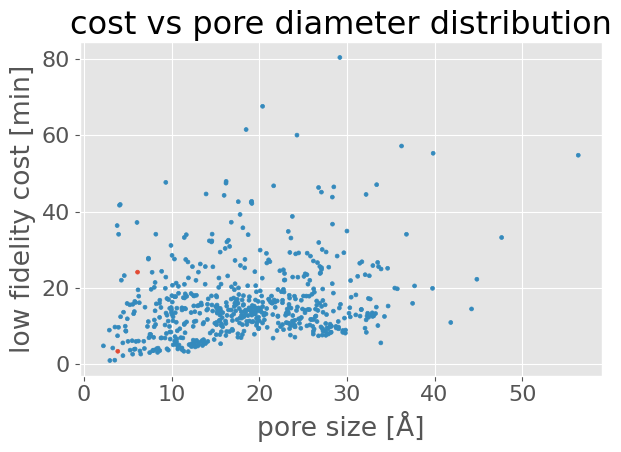

In [12]:
fig = figure()

# name in benchmarked_cofs ? opt = plot_opt(true) : opt = plot_opt(false)
scatter(descriptors[:, "pore_diameter_Å"], df[:, :henry_total_elapsed_time], color=mkr_c, s=mkr_sz)

title("cost vs pore diameter distribution")
xlabel("pore size [Å]")
ylabel("low fidelity cost [min]")

tight_layout()

In [13]:
# fig = figure()

# scatter(descriptors[:, "pore_diameter_Å"], df[:, :gcmc_elapsed_time], color=mkr_c, s=mkr_sz)

# xlim(xmax=100)
# ylim(ymax=500)
# # gca().set_aspect("equal", adjustable="box")

# title("cost vs pore diameter distribution")
# xlabel("pore size [Å]")
# ylabel("high fidelity cost [min]")

# tight_layout()

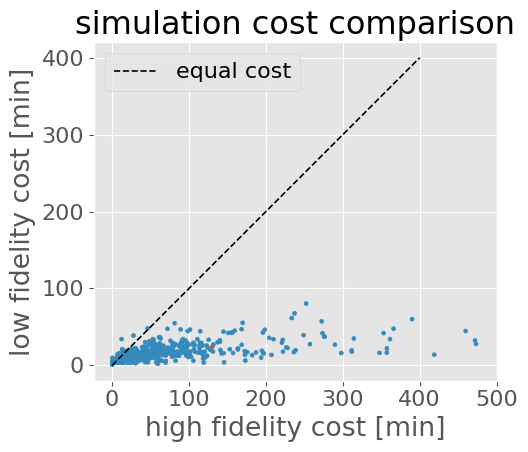

cost ratio: 0.11986863711001643 unfavorable, 0.8801313628899836 favorable


In [14]:
figure()

scatter(df[:, :gcmc_elapsed_time], df[:, :henry_total_elapsed_time], color=mkr_c, s=mkr_sz)

# track fraction above or on the equal cost line
unfavorable = sum(sum.(df[:, :henry_elapsed_time]) .>= df[:, :gcmc_elapsed_time])
favorable = length(df[:, :gcmc_elapsed_time]) - unfavorable

cost_ratio = unfavorable / length(df[:, :gcmc_elapsed_time])
println("cost ratio: $(cost_ratio) unfavorable, $(1 - cost_ratio) favorable")

# plot the line: y=x
x = range(0.0, stop=400, length=100)
y = x
plot(x, y; label="equal cost", color="k", linestyle="--", linewidth=1.2)

xlim(xmax=500.0)
# ylim([0.0, 500.0])
# note: make axis equal
gca().set_aspect("equal", adjustable="box")

title("simulation cost comparison")
legend()
xlabel("high fidelity cost [min]")
ylabel("low fidelity cost [min]")

tight_layout()

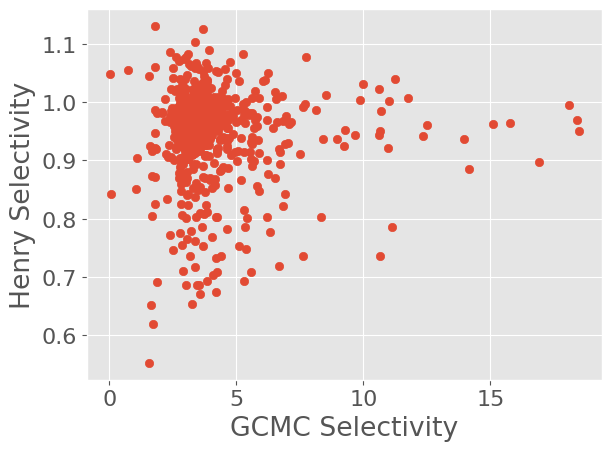

In [15]:
figure()

scatter(df[:, :gcmc_selectivity], df[:, :henry_selectivity])
xlabel("GCMC Selectivity")
ylabel("Henry Selectivity")
tight_layout()